In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the dataset
matches = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/matches.csv', index_col=-0)
matches

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,referee,match report,notes,sh,sot,dist,fk,pk,pkatt,team
0,2024-08-17,12:30,Premier League,Matchweek 1,Sat,Away,W,2.0,0.0,Ipswich Town,...,Tim Robinson,Match Report,NaN,18.0,5.0,14.8,0.0,0,0,Liverpool
1,2024-08-25,16:30,Premier League,Matchweek 2,Sun,Home,W,2.0,0.0,Brentford,...,Stuart Attwell,Match Report,NaN,19.0,8.0,13.6,1.0,0,0,Liverpool
2,2024-09-01,16:00,Premier League,Matchweek 3,Sun,Away,W,3.0,0.0,Manchester Utd,...,Anthony Taylor,Match Report,NaN,11.0,3.0,13.4,0.0,0,0,Liverpool
3,2024-09-14,15:00,Premier League,Matchweek 4,Sat,Home,L,0.0,1.0,Nott'ham Forest,...,Michael Oliver,Match Report,NaN,14.0,5.0,14.9,0.0,0,0,Liverpool
5,2024-09-21,15:00,Premier League,Matchweek 5,Sat,Home,W,3.0,0.0,Bournemouth,...,Tony Harrington,Match Report,NaN,19.0,12.0,16.6,0.0,0,0,Liverpool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2021-05-02,19:15,Premier League,Matchweek 34,Sun,Away,L,0.0,4.0,Tottenham,...,Andre Marriner,Match Report,NaN,8.0,1.0,18.2,0.0,0,0,Sheffield United
39,2021-05-08,15:00,Premier League,Matchweek 35,Sat,Home,L,0.0,2.0,Crystal Palace,...,Simon Hooper,Match Report,NaN,7.0,0.0,13.4,1.0,0,0,Sheffield United
40,2021-05-16,19:00,Premier League,Matchweek 36,Sun,Away,W,1.0,0.0,Everton,...,Jonathan Moss,Match Report,NaN,10.0,3.0,18.5,0.0,0,0,Sheffield United
41,2021-05-19,18:00,Premier League,Matchweek 37,Wed,Away,L,0.0,1.0,Newcastle Utd,...,Robert Jones,Match Report,NaN,11.0,1.0,18.3,1.0,0,0,Sheffield United


In [5]:
print(matches.head())
print(matches.shape)

         date   time            comp        round  day venue result   gf   ga  \
0  2024-08-17  12:30  Premier League  Matchweek 1  Sat  Away      W  2.0  0.0   
1  2024-08-25  16:30  Premier League  Matchweek 2  Sun  Home      W  2.0  0.0   
2  2024-09-01  16:00  Premier League  Matchweek 3  Sun  Away      W  3.0  0.0   
3  2024-09-14  15:00  Premier League  Matchweek 4  Sat  Home      L  0.0  1.0   
5  2024-09-21  15:00  Premier League  Matchweek 5  Sat  Home      W  3.0  0.0   

          opponent  ...          referee  match report  notes    sh   sot  \
0     Ipswich Town  ...     Tim Robinson  Match Report    NaN  18.0   5.0   
1        Brentford  ...   Stuart Attwell  Match Report    NaN  19.0   8.0   
2   Manchester Utd  ...   Anthony Taylor  Match Report    NaN  11.0   3.0   
3  Nott'ham Forest  ...   Michael Oliver  Match Report    NaN  14.0   5.0   
5      Bournemouth  ...  Tony Harrington  Match Report    NaN  19.0  12.0   

   dist   fk pk pkatt       team  
0  14.8  0.0  0

In [6]:
# Clean and preprocess the data
matches["date"] = pd.to_datetime(matches["date"])
matches["target"] = (matches["result"] == "W").astype("int")

# Encode categorical variables
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek

# Remove unnecessary columns
matches.drop(columns=["comp", "notes"], inplace=True)

In [7]:
matches

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,dist,fk,pk,pkatt,team,target,venue_code,opp_code,hour,day_code
0,2024-08-17,12:30,Matchweek 1,Sat,Away,W,2.0,0.0,Ipswich Town,2.6,...,14.8,0.0,0,0,Liverpool,1,0,10,12,5
1,2024-08-25,16:30,Matchweek 2,Sun,Home,W,2.0,0.0,Brentford,2.5,...,13.6,1.0,0,0,Liverpool,1,1,3,16,6
2,2024-09-01,16:00,Matchweek 3,Sun,Away,W,3.0,0.0,Manchester Utd,1.8,...,13.4,0.0,0,0,Liverpool,1,0,16,16,6
3,2024-09-14,15:00,Matchweek 4,Sat,Home,L,0.0,1.0,Nott'ham Forest,0.9,...,14.9,0.0,0,0,Liverpool,0,1,19,15,5
5,2024-09-21,15:00,Matchweek 5,Sat,Home,W,3.0,0.0,Bournemouth,2.0,...,16.6,0.0,0,0,Liverpool,1,1,2,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2021-05-02,19:15,Matchweek 34,Sun,Away,L,0.0,4.0,Tottenham,0.5,...,18.2,0.0,0,0,Sheffield United,0,0,22,19,6
39,2021-05-08,15:00,Matchweek 35,Sat,Home,L,0.0,2.0,Crystal Palace,0.7,...,13.4,1.0,0,0,Sheffield United,0,1,7,15,5
40,2021-05-16,19:00,Matchweek 36,Sun,Away,W,1.0,0.0,Everton,1.2,...,18.5,0.0,0,0,Sheffield United,1,0,8,19,6
41,2021-05-19,18:00,Matchweek 37,Wed,Away,L,0.0,1.0,Newcastle Utd,0.9,...,18.3,1.0,0,0,Sheffield United,0,0,17,18,2


In [8]:
# Define rolling averages function
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

# Define columns for rolling averages
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

# Apply rolling averages grouped by team
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.index = range(matches_rolling.shape[0])

# Inspect processed data
print(matches_rolling.head())

        date   time        round  day venue result   gf   ga         opponent  \
0 2020-10-04  14:00  Matchweek 4  Sun  Home      W  2.0  1.0    Sheffield Utd   
1 2020-10-17  17:30  Matchweek 5  Sat  Away      L  0.0  1.0  Manchester City   
2 2020-10-25  19:15  Matchweek 6  Sun  Home      L  0.0  1.0   Leicester City   
3 2020-11-01  16:30  Matchweek 7  Sun  Away      W  1.0  0.0   Manchester Utd   
4 2020-11-08  19:15  Matchweek 8  Sun  Home      L  0.0  3.0      Aston Villa   

    xg  ...  hour  day_code  gf_rolling ga_rolling sh_rolling sot_rolling  \
0  0.6  ...    14         6    2.000000   1.333333   8.000000    3.666667   
1  0.9  ...    17         5    1.666667   1.666667   5.666667    3.666667   
2  0.7  ...    19         6    1.000000   1.666667   7.000000    3.666667   
3  1.0  ...    16         6    0.666667   1.000000   9.666667    4.000000   
4  1.5  ...    19         6    0.333333   0.666667   9.666667    2.666667   

  dist_rolling fk_rolling  pk_rolling  pkatt_rolli

<ipython-input-8-d435dfc45728>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))


In [9]:
# Select features and target
features = ["venue_code", "opp_code", "hour", "day_code"] + new_cols
target = "target"

# Normalize features
scaler = StandardScaler()
matches_rolling[features] = scaler.fit_transform(matches_rolling[features])

# Create sequences for LSTM
def create_sequences(data, target_col, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length][features].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X), np.array(y)

# Split into training and testing sets
train_data = matches_rolling[matches_rolling["date"] < '2022-01-01']
test_data = matches_rolling[matches_rolling["date"] > '2022-01-01']

X_train, y_train = create_sequences(train_data, target)
X_test, y_test = create_sequences(test_data, target)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (1051, 3, 12) (1051,)
Testing data shape: (2211, 3, 12) (2211,)


In [10]:
# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=40,
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 64)               │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5753 - loss: 0.6824 - val_accuracy: 0.6210 - val_loss: 0.6612
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6411 - loss: 0.6448 - val_accuracy: 0.6210 - val_loss: 0.6548
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6236 - loss: 0.6463 - val_accuracy: 0.6201 - val_loss: 0.6532
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6672 - loss: 0.6159 - val_accuracy: 0.6219 - val_loss: 0.6528
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6685 - loss: 0.6303 - val_accuracy: 0.6242 - val_loss: 0.6521
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6574 - loss: 0.6299 - val_accuracy: 0.6147 - val_loss: 0.6542
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6498 - loss: 0.6381 - val_accuracy: 0.6242 - val_loss: 0.6518
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6341 - loss: 0.6360 - val_accuracy: 0.6264 - v

In [11]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict outcomes
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Display evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5700 - loss: 0.7647
Test Accuracy: 0.59
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Confusion Matrix:
 [[964 389]
 [507 351]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.68      1353
           1       0.47      0.41      0.44       858

    accuracy                           0.59      2211
   macro avg       0.56      0.56      0.56      2211
weighted avg       0.59      0.59      0.59      2211



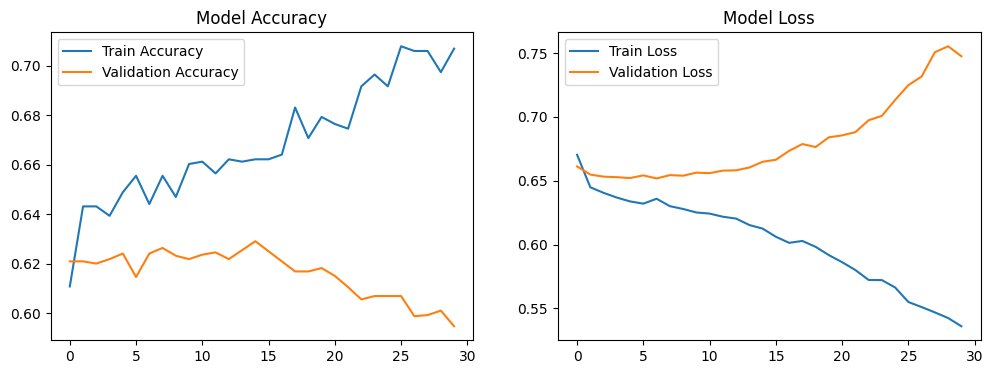

In [12]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [13]:
# Integrate predictions
lstm_combined = pd.DataFrame(dict(actual=y_test, predicted=y_pred.flatten()), index=test_data.index[3:])
pd.crosstab(index=lstm_combined["actual"], columns=lstm_combined["predicted"])


predicted,0,1
actual,,
0,964,389
1,507,351
